# ETH breakout strategy

- Description: TODO

# Set up

Set up Trading Strategy data client.


In [51]:
from tradingstrategy.client import Client

from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [52]:
import datetime
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "eth-breakout-atr-lending-1h-dex" # Used in cache paths

    cycle_duration = CycleDuration.h1
    candle_time_bucket = TimeBucket.h1
    allocation = 0.98

    atr_length = 10  #
    fract = 3.0  # Fraction between last hourly close and breakout level

    adx_length = 14  # 14 days
    adx_filter_threshold = 15

    trailing_stop_loss_pct = 0.98
    trailing_stop_loss_activation_level = 1.075
    stop_loss_pct = 0.98

    #
    # Live trading only
    #
    chain_id = ChainId.polygon
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = datetime.timedelta(hours=200)

    #
    # Backtesting only
    #

    use_binance_data = False
    if use_binance_data:
        # Perform backesting on binance data instead of DEX data, allows longer backtesting period
        #backtest_start = datetime.datetime(2019, 8, 1)
        backtest_start = datetime.datetime(2022, 8, 1)
        backtest_end = datetime.datetime(2024, 5, 15)
    else:
        # WETH-USDC 5 BPS is not available on Polygon unti 2022-08
        backtest_start = datetime.datetime(2022, 8, 1)
        backtest_end = datetime.datetime(2024, 5, 15)

    stop_loss_time_bucket = TimeBucket.m5
    backtest_trading_fee = 0.0005  # Override the default Binance data trading fee and assume we can trade 5 BPS fee on WMATIC-USDC on Polygon on Uniswap v3
    initial_cash = 10_000

    # Use Aave pools when avaible
    # We cannot do lending tests in if we are using Binance data for the strategy backtest,
    # as Binance does not have a lending market
    lending_enabled = not use_binance_data

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Quickswap data so we have longer history to backtest

In [53]:
from tradeexecutor.utils.binance import create_binance_universe
from tradingstrategy.client import Client
from tradingstrategy.lending import LendingProtocolType

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions

if not Parameters.use_binance_data:

    # List of trading pairs we use in the backtest
    # In this backtest, we use Binance data as it has more price history than DEXes
    trading_pairs = [
        (ChainId.polygon, "uniswap-v3", "WETH", "USDC"),
    ]

    # We use Aave v3 pool to store our excess cash when we are out of the market
    lending_reserves = [
        (ChainId.polygon, LendingProtocolType.aave_v3, "USDC.e"),
    ]
else:

    trading_pairs = [
        (ChainId.centralised_exchange, "binance", "ETH", "USDT")
    ]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - For live trading, we load DEX data

    - We backtest with Binance data, as it has more history
    """


    if Parameters.use_binance_data:

        assert not Parameters.lending_enabled, "Cannot use Aave lending with Binance trading"

        start_at = universe_options.start_at
        end_at = universe_options.end_at
        strategy_universe = create_binance_universe(
            [f"{p[2]}{p[3]}" for p in trading_pairs],
            candle_time_bucket=Parameters.candle_time_bucket,
            stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
            start_at=start_at,
            end_at=end_at,
            trading_fee_override=Parameters.backtest_trading_fee,
        )
    else:
        dataset = load_partial_data(
            client=client,
            time_bucket=Parameters.candle_time_bucket,
            pairs=trading_pairs,
            execution_context=execution_context,
            universe_options=universe_options,
            liquidity=False,
            stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
            lending_reserves=lending_reserves,
        )
        # Construct a trading universe from the loaded data,
        # and apply any data preprocessing needed before giving it
        # to the strategy and indicators
        strategy_universe = TradingStrategyUniverse.create_from_dataset(
            dataset,
            reserve_asset="USDC",
            forward_fill=True,
        )

    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk

In [54]:
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def daily_price(open, high, low, close) -> pd.DataFrame:
    """Resample pricees to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    return daily_df


def daily_adx(open, high, low, close, length):
    daily_df = daily_price(open, high, low, close)
    adx_df = pandas_ta.adx(
        close=daily_df.close,
        high=daily_df.high,
        low=daily_df.low,
        length=length,
    )
    return adx_df


def regime(open, high, low, close, length, regime_threshold) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """
    adx_df = daily_adx(open, high, low, close, length)
    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values
        if directional_momentum_positive > regime_threshold:
            return Regime.bull.value
        elif directional_momentum_negative > regime_threshold:
            return Regime.bear.value
        else:
            return Regime.crab.value
    regime_signal = adx_df.apply(regime_filter, axis="columns")    
    return regime_signal



def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/volatility/atr.py
    indicators.add(
        "atr",
        pandas_ta.atr,
        {"length": parameters.atr_length},
        IndicatorSource.ohlcv,
    )

    # ADX https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp
    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/adx.py
    indicators.add(
        "adx",
        daily_adx,
        {"length": parameters.adx_length},
        IndicatorSource.ohlcv,
    )

    # Price OHLC resampled to daily
    indicators.add(
        "daily_price",
        daily_price,
        {},
        IndicatorSource.ohlcv,
    )

    # A regime filter to detect the trading pair bear/bull markets
    indicators.add(
        "regime",
        regime,
        {"length": parameters.adx_length, "regime_threshold": parameters.adx_filter_threshold},
        IndicatorSource.ohlcv,
    )
        
    return indicators


# Trading algorithm

- Describe out trading strategy as code

In [55]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    #
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    pair = strategy_universe.get_single_pair()
    cash = position_manager.get_current_cash()

    #
    # Indicators
    #

    close_price = indicators.get_price()  # Price the previous 15m candle closed for this decision cycle timestamp
    atr = indicators.get_indicator_value("atr")  # The ATR value at the time of close price
    point_of_interest = (timestamp - parameters.cycle_duration.to_pandas_timedelta()).floor(freq="D")  # POI (point of interest): Account 15m of lookahead bias whehn using decision cycle timestamp
    previous_price = indicators.get_price(timestamp=point_of_interest)  # The price at the start of this hour
    regime_val = indicators.get_indicator_value("regime", data_delay_tolerance=pd.Timedelta(hours=24))  # Because the regime filter is calculated only daily, we allow some lookback

    if None in (atr, close_price, previous_price):
        # Not enough historic data,
        # cannot make decisions yet
        return []

    # If regime filter does not have enough data at the start of the backtest,
    # default to bull market
    if regime_val is None:
        regime = Regime.bull

    else:
        regime = Regime(regime_val)  # Convert to enum for readability

    #
    # Trading logic
    #

    trades = []

    # We assume a breakout if our current 15m candle has closed
    # above the 1h starting price + (atr * fraction) target level
    long_breakout_entry_level = previous_price + atr * parameters.fract

    # Check for open condition - is the price breaking out
    #
    if not position_manager.is_any_long_position_open():

        if regime == Regime.bull:
            if close_price > long_breakout_entry_level:

                # Unwind credit position to have cash to take a directional position
                if parameters.lending_enabled and position_manager.is_any_credit_supply_position_open():
                    credit_supply_position = position_manager.get_current_credit_supply_position()
                    trades += position_manager.close_credit_supply_position(credit_supply_position)
                    cash = float(credit_supply_position.get_quantity())

                trades += position_manager.open_spot(
                    pair,
                    value=cash * parameters.allocation,
                    stop_loss_pct=parameters.stop_loss_pct,
                )
    else:
        # Enable trailing stop loss after we reach the profit taking level
        #
        for position in state.portfolio.open_positions.values():
            if position.trailing_stop_loss_pct is None:
                close_price = indicators.get_price(position.pair)
                if close_price >= position.get_opening_price() * parameters.trailing_stop_loss_activation_level:
                    position.trailing_stop_loss_pct = parameters.trailing_stop_loss_pct

    # Move all cash to to Aave credit to earn interest
    if parameters.lending_enabled:
        if not position_manager.is_any_credit_supply_position_open() and not position_manager.is_any_long_position_open():
            amount = cash * 0.9999
            trades += position_manager.open_credit_supply_position_for_reserves(amount)

    # Visualisations
    #
    if input.is_visualisation_enabled():
        visualisation = state.visualisation
        visualisation.plot_indicator(timestamp, "ATR", PlotKind.technical_indicator_detached, atr)

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [56]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    strategy_logging=False,
    max_workers=1
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators atr, adx, daily_price, regime for 1 pairs, using 8 threads:   0%|          | 0/4 [00…

Using indicator cache /Users/moo/.cache/indicators/polygon_1h_WETH-USDC_2022-08-01-2024-05-15_ff


  0%|          | 0/56419200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 361 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against MATIC buy and hold

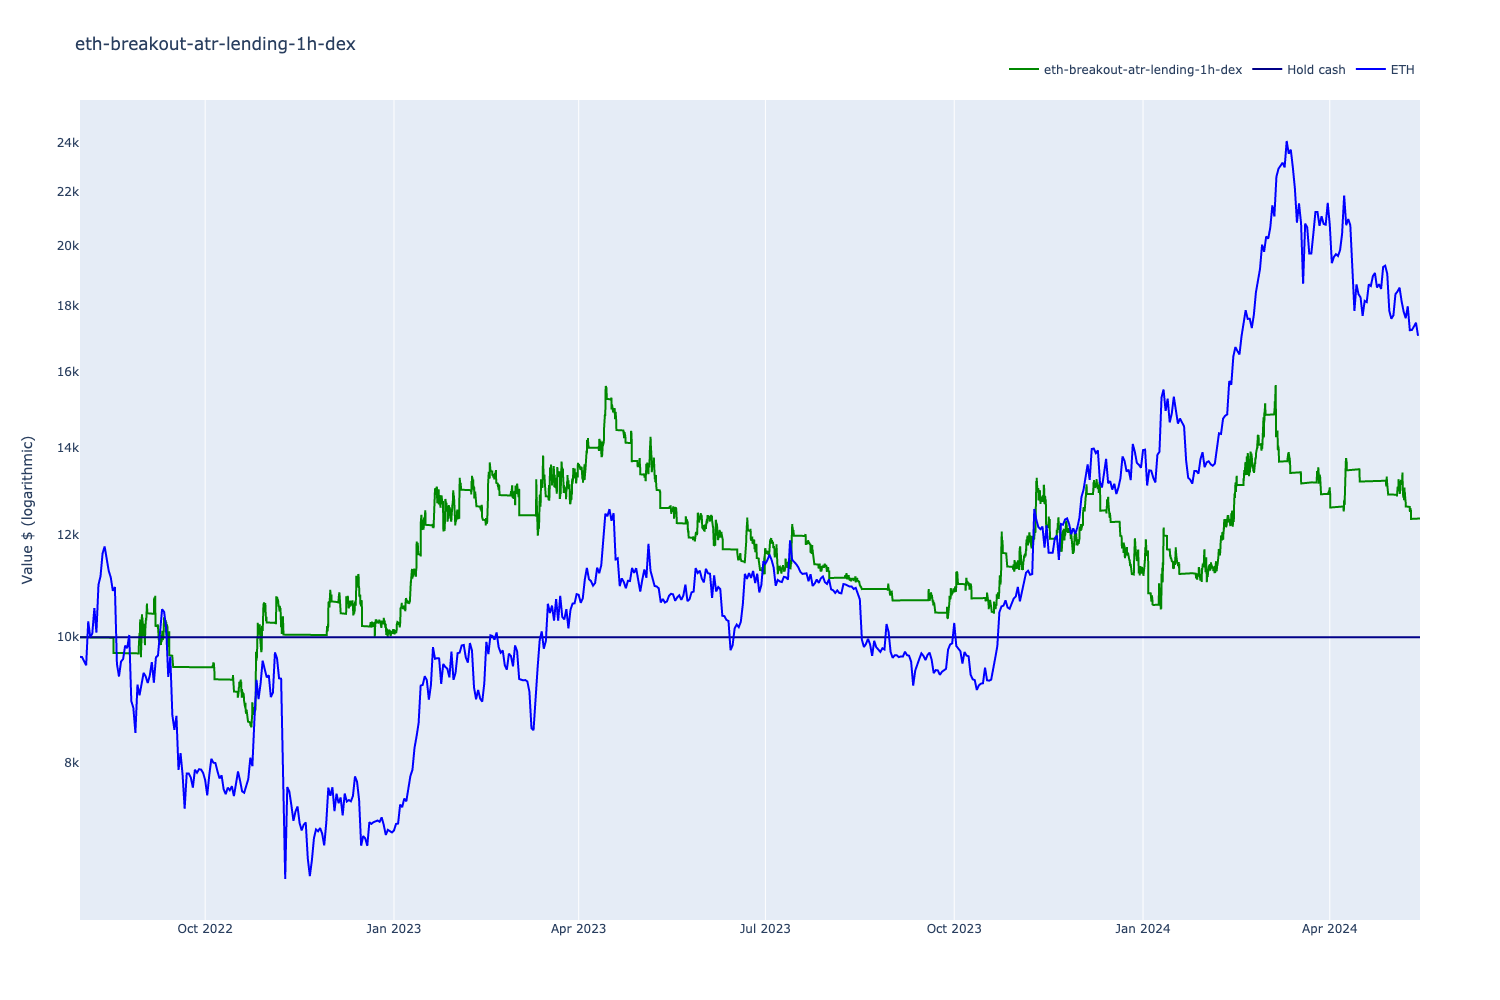

In [57]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash()
)

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Technical indicator and trade visualisation

- Draw the technical indicators we filled in in `decide_trades()`
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study.
  However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

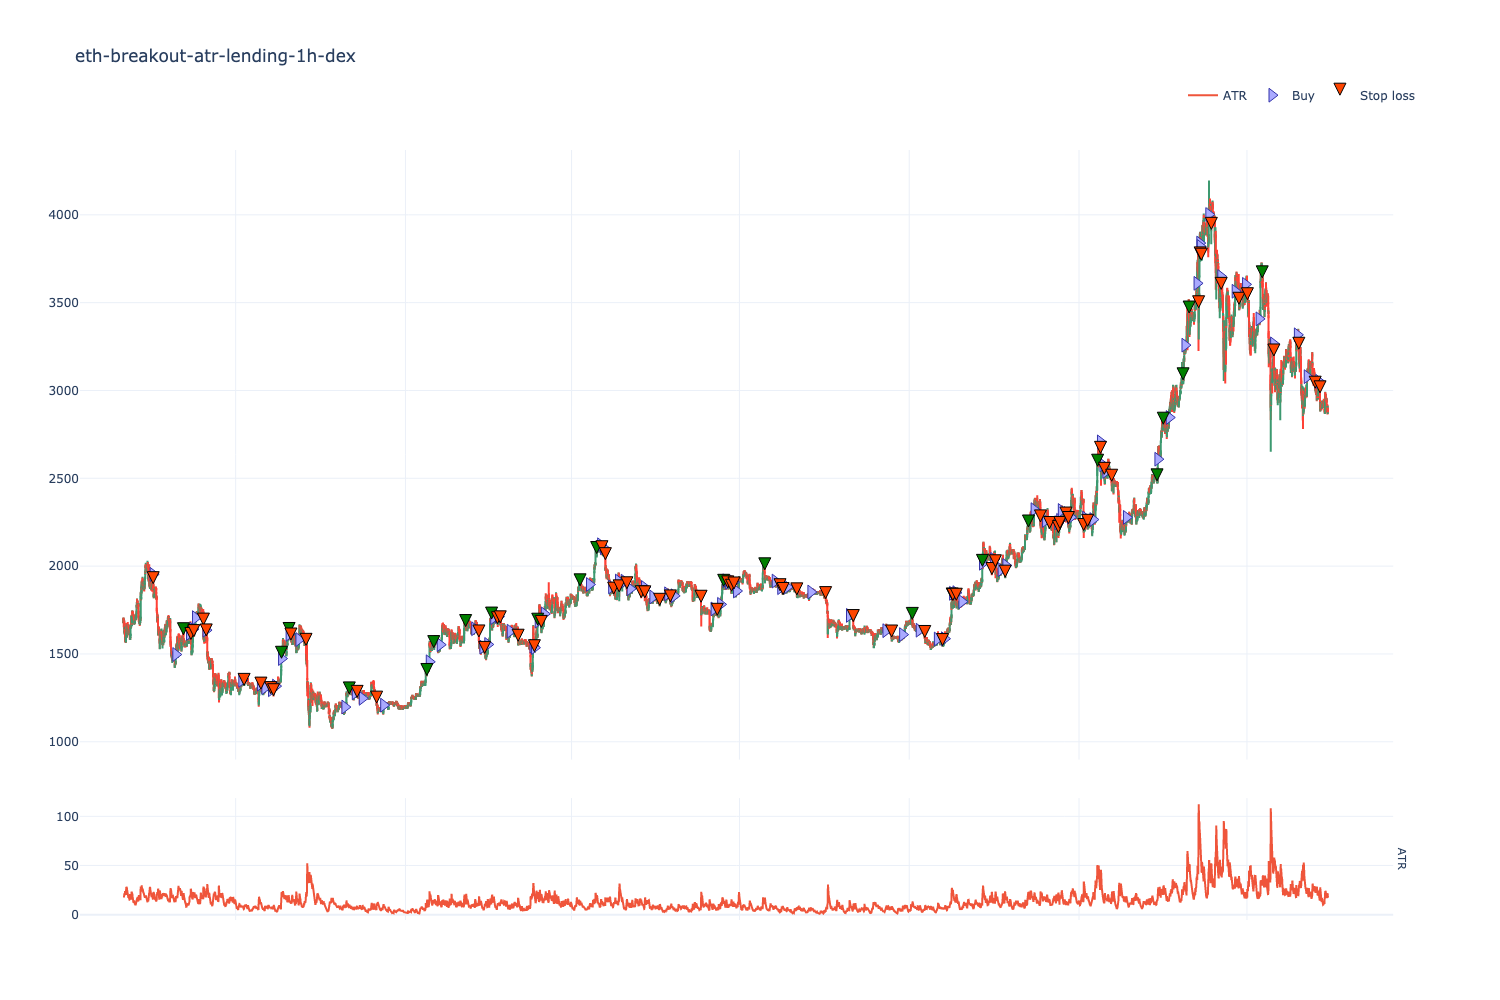

In [58]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_single_pair(
    state,
    execution_context=notebook_execution_context,
    candle_universe=strategy_universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

# Regime filter visualisation 

- Visualise the regime filter to show how well our bear/bull market flagging works


In [59]:
# Pull the pair and its close price we are detecting regimes for
indicators = result.indicators
daily_price = indicators.get_indicator_dataframe("daily_price", pair=trading_pairs[0])
close_price = daily_price["close"]

Lay out the regime filter signal on the top of price chart.

- Green: bull market regime detected
- Red: bear market regime detected
- No background colour: sideways (crab) market detected

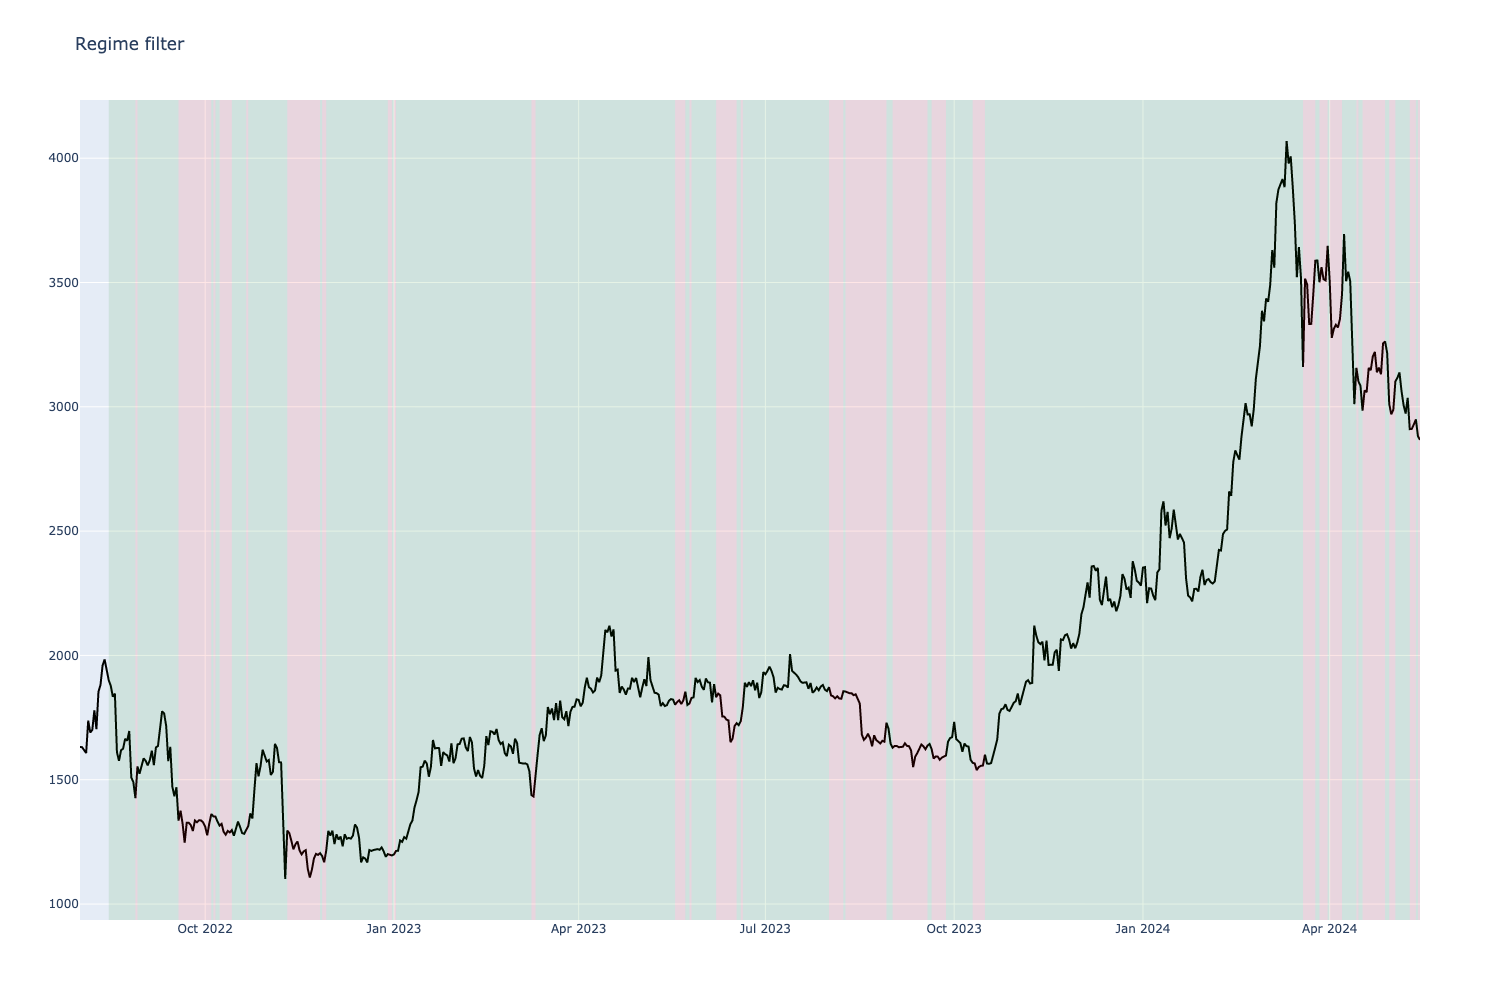

In [60]:
from tradeexecutor.visual.bullbear import visualise_market_regime_filter

regime_signal = result.indicators.get_indicator_series("regime", pair=trading_pairs[0], unlimited=True)
visualise_market_regime_filter(
    close_price,
    regime_signal,
)

Visualise raw ADX data so we have an idea what are good threshold levels for the regime filtering.

 - ADX = [Average Directional Index](https://www.investopedia.com/terms/a/adx.asp)
 - DMP = Directional Movement Positive
 - DMN = Directional Movement Negative

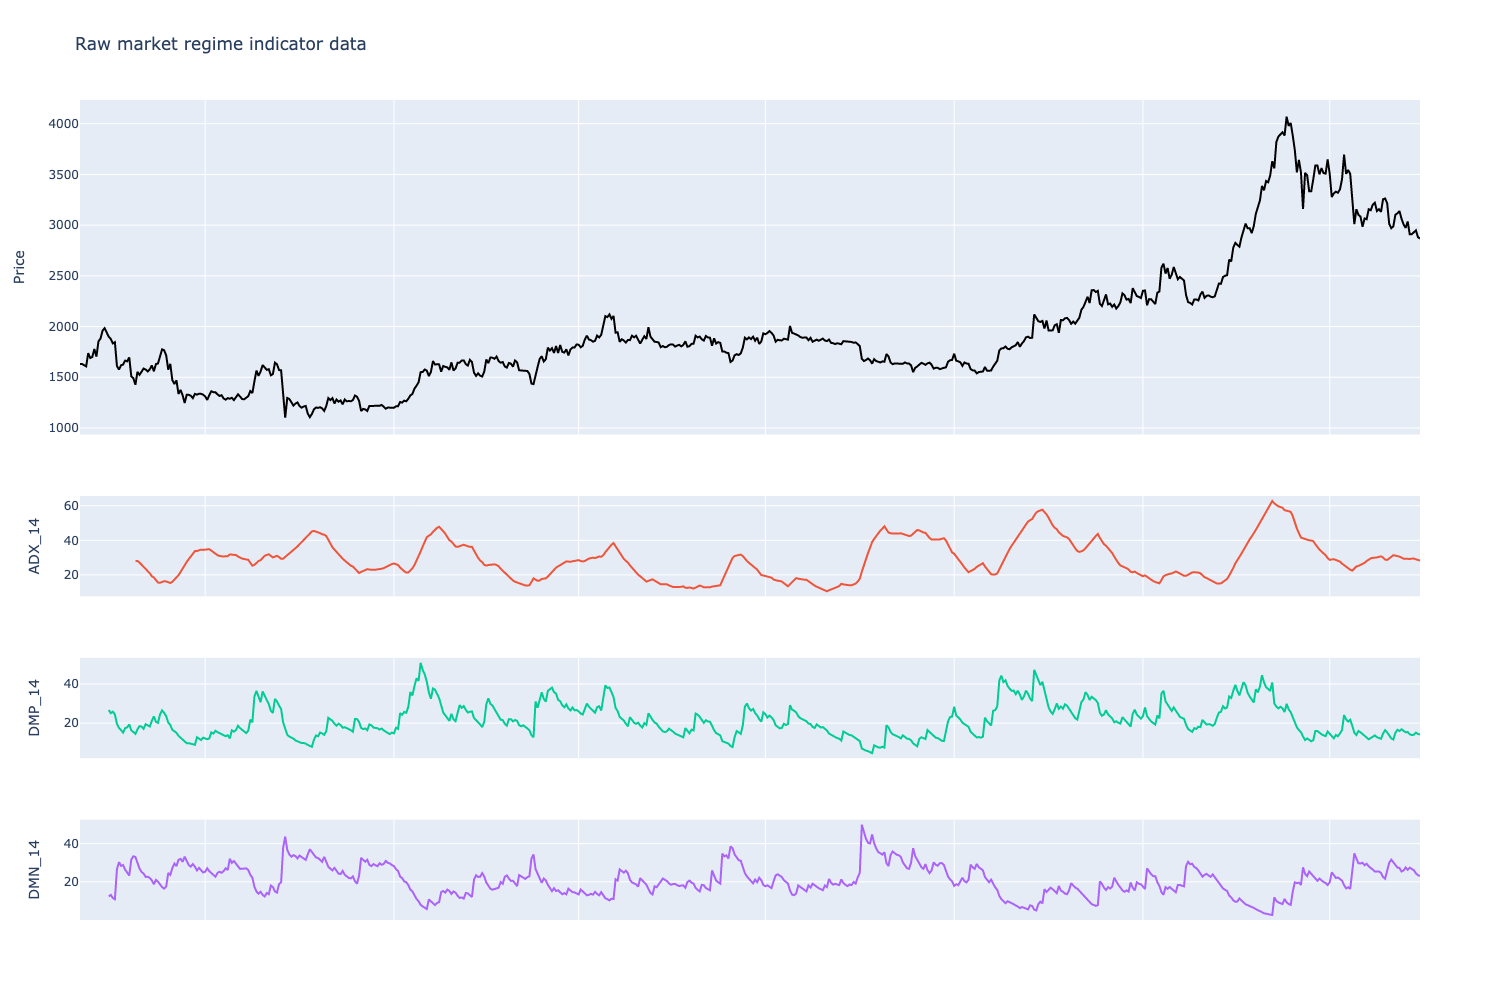

In [61]:
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

adx_df = result.indicators.get_indicator_dataframe("adx")
visualise_raw_market_regime_indicator(
    close_price, 
    adx_df,
    height=500,
    indicator_height=150,
)


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

In [62]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

Strategy         ETH
Start Period             2022-08-01  2022-08-01
End Period               2024-05-14  2024-05-14
Risk-Free Rate                 0.0%        0.0%
Time in Market               100.0%      100.0%
Cumulative Return            23.42%      76.61%
CAGR﹪                         12.5%      37.49%
Sharpe                         0.51        0.83
Prob. Sharpe Ratio           75.58%      86.67%
Sortino                        0.84        1.21
Sortino/√2                     0.59        0.86
Omega                           1.1         1.1
Max Drawdown                -32.23%     -44.52%
Longest DD Days                 393         242
Gain/Pain Ratio                 0.1        0.14
Gain/Pain (1M)                 0.54        1.22
Payoff Ratio                   0.55        1.16
Profit Factor                   1.1        1.14
Common Sense Ratio              1.4        1.25
CPC Index                       0.4        0.66
Tail Ratio                     1.27         1.1
Outlier Win Ratio              8.53        3.39
Outlier Loss Ratio             3.17        3.38
MTD                          -4.18%      -4.31%
3M                            0.26%       9.07%
6M                            -3.7%      40.21%
YTD                          10.57%      26.34%
1Y                           -1.84%      60.41%
3Y (ann.)                     12.5%      37.49%
5Y (ann.)                     12.5%      37.49%
10Y (ann.)                    12.5%      37.49%
All-time (ann.)               12.5%      37.49%
Avg. Drawdown                -6.81%      -8.47%
Avg. Drawdown Days               37          32
Recovery Factor                0.73        1.72
Ulcer Index                    0.18         0.2
Serenity Index                 0.08        0.33
Annualised return (raw)    0.124993         NaN

# Trading statistics

- Display summare about made trades

In [63]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Rolling Sharpe

- See how the six months rolling Sharpe ratio changes over time

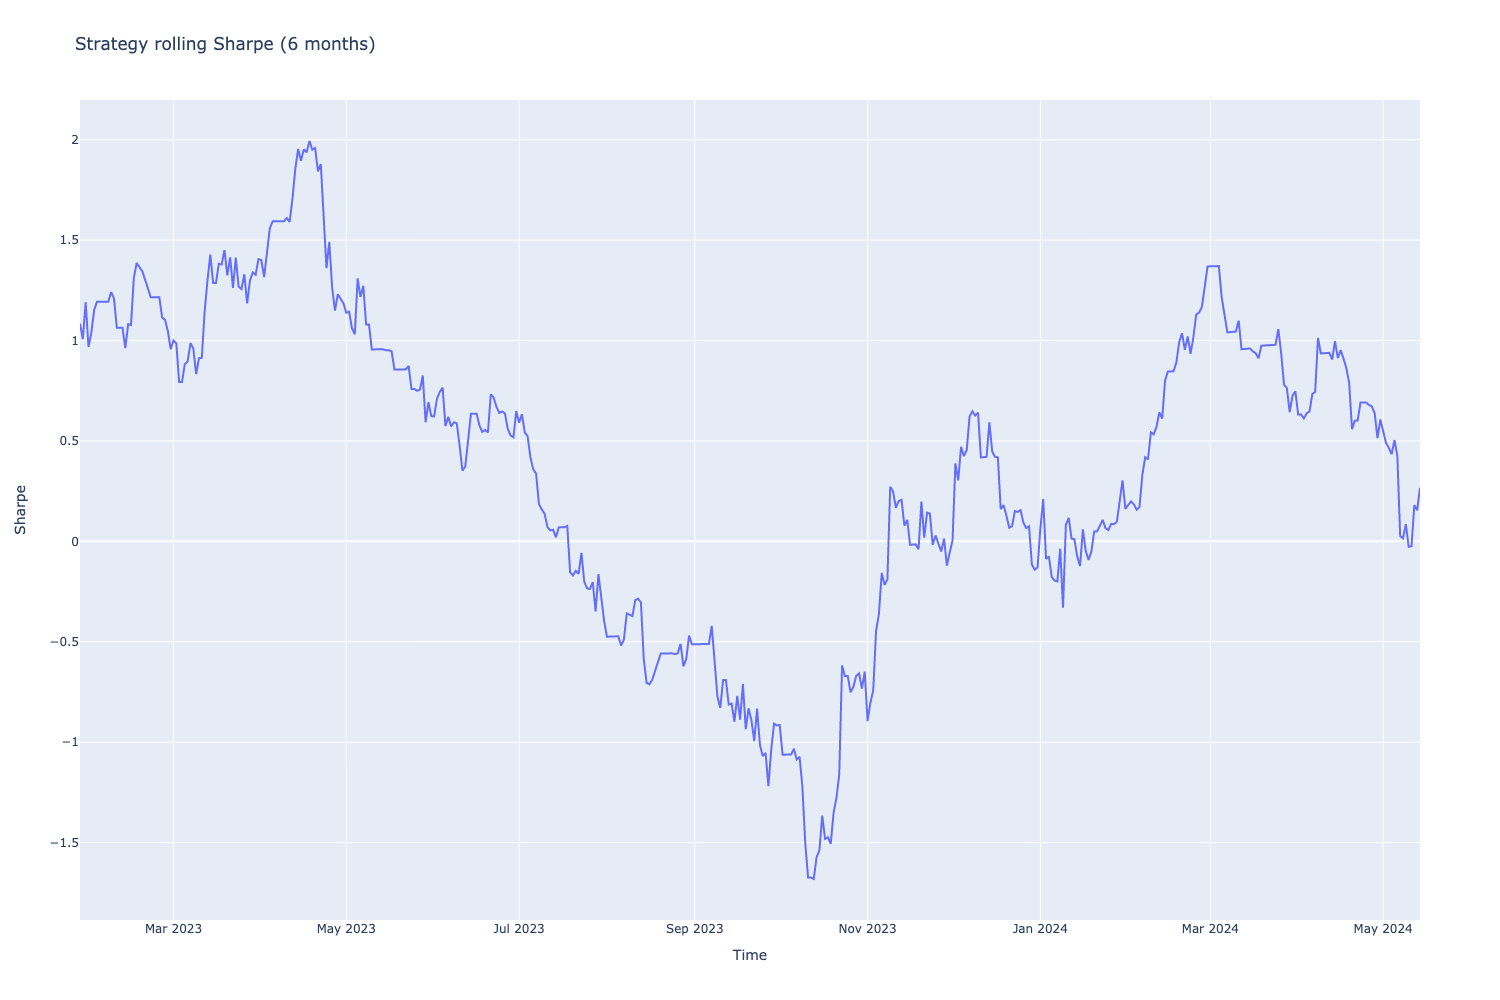

In [64]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()